In [1]:
## Plotting/other packages
import os
import h5py
import math
import time
from typing import Set, List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import diffrax as dfx
from diffrax import diffeqsolve, Dopri5, Tsit5, ODETerm, SaveAt, PIDController
import pprint as pp
import jax
from jax import lax, grad, random, jacfwd, jacrev, jit
import jax.numpy as jnp
import equinox as eqx


from cdcm_utils.cdcm_jax import *
from cdcm import *
from duffing_oscillator import make_duff_osc_sys

#### Utilities ####

In [2]:
def plot_prediction(data_dict, sys, test_saver, t_data):
    x1_data = data_dict[sys.dho.x1]
    x2_data = data_dict[sys.dho.x2]
    x1_pred = fetch_save_data(
        path=f"{sys.name}/dho/x1",
        test_saver=test_saver,
    )
    x2_pred = fetch_save_data(
        path=f"{sys.name}/dho/x2",
        test_saver=test_saver,
    )
    fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
    ax.plot(t_data,x1_data,'c',label='x1_data')
    ax.plot(t_data, x2_data,'y',label='x2_data')
    ax.plot(t_data, x1_pred,'r--',label='x1 pred')
    ax.plot(t_data, x2_pred,'k-.',label='x2 pred')
    plt.legend()
    plt.show()


def get_simuln_result(sys, max_steps, data_dict):
    def set_ic():
        if data_dict:
            sns = list(data_dict.keys())
            for sn in sns:
                sn.value = data_dict[sn][0]
        
    file_name = "damped_simple_harmonic_egs.h5"

    if os.path.exists(file_name):
        os.remove(file_name)

    saving_frac = 1 # saving done every saving_frac*dt instant
    test_saver = SimulationSaver(
        file_name,
        sys,
        max_steps=math.ceil(max_steps/saving_frac)
    )
    simulator = Simulator(sys)

    now = time.time()
    simulator.add_event(0., set_ic)
    for i in range(max_steps):
        simulator.forward()
        if i%saving_frac==0:
            test_saver.save()
        simulator.transition()
    print('time taken (s)',time.time()-now)
    return test_saver


def fetch_save_data(path,test_saver,sp=''):
    res = test_saver.file_handler[path][:]
    if sp:
        np.savetxt(sp, res, delimiter=",")
        print('saved')
    return res

get_names = lambda x: [i.name for i in x]

### cdcm system and simulation ###

In [3]:
dt = 0.001
max_steps = 250*20
to_s = 0.
tmax_s = max_steps*dt
t_data = np.arange(0.,max_steps*dt,dt)
force_data = np.cos(t_data)
input_dict = {"force":force_data}

input_data_df = pd.DataFrame(input_dict)
input_data_df.head()
input_data = {
    "data":input_data_df,
    "name":"input_sys",
}
kwargs = {"input_data":input_data}
duff_osc_sys = make_duff_osc_sys(
    dt = dt,
    name="duff_osc_sys",
    **kwargs,
)

time taken (s) 4.258119106292725


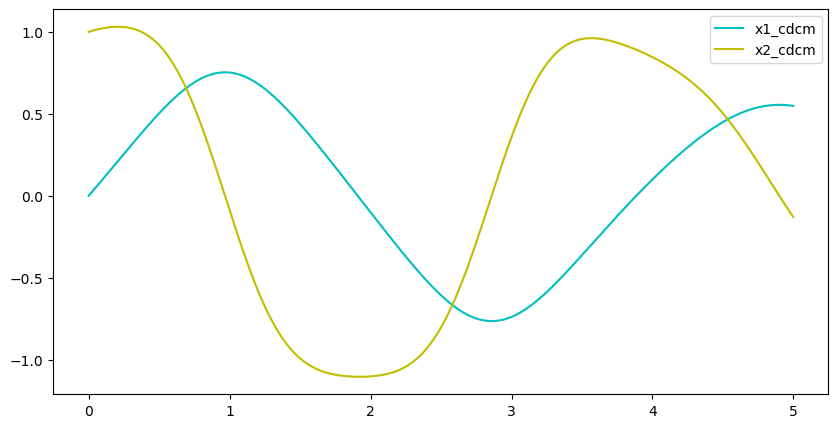

In [4]:
sim = 1
if sim:
    cdcm_simn_res = get_simuln_result(
        sys=duff_osc_sys,
        max_steps=max_steps,
        data_dict={}
    )
    
    fig, ax = plt.subplots(1,1, figsize = (10, 5), facecolor="w", edgecolor="k")
    x1s = fetch_save_data(
                "duff_osc_sys/duff_osc/x1",
                cdcm_simn_res,
            )
    x2s = fetch_save_data(
                "duff_osc_sys/duff_osc/x2",
                cdcm_simn_res,
            )
    ax.plot(t_data,x1s,'c',label='x1_cdcm')
    ax.plot(t_data, x2s,'y',label='x2_cdcm')
    plt.legend()
    plt.show()

### cdcm to diffrax ###

In [5]:
vector_field, params_set, vars_set, states_set, ofl = get_vector_field(
duff_osc_sys,t_data,input_dict,dt,)

In [6]:
print(get_names(states_set))
sol_idx = [get_names(states_set).index(i) for i in ['x1','x2']]
print(sol_idx)

['x2', 'x1']
[1, 0]


In [7]:
#print(duff_osc_sys.sys_dag_for_diffrax)

In [8]:
args=[i.value for i in params_set]
args[get_names(params_set).index('dt')]=dt

In [9]:
key, subkey = random.split(random.PRNGKey(1234))
x0 = np.zeros(2)
x0[sol_idx[0]] = 0.
x0[sol_idx[1]] = 1.


import time
now = time.time()

@jit
def ODESolver(args):
    sol = diffeqsolve(
        ODETerm(vector_field),
        Tsit5(),
        #Dopri5(), 
        to_s, 
        tmax_s, 
        dt0=dt, #cdcm_sys.clock.dt.value,
        y0=x0,
        args=args, 
        saveat=SaveAt(ts=t_data),
        #AD through Solver graph, only reverse mode
        adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=200), 
        
        #Both forward and reverse mode. Prefer only if forward mode req else
        # RecursiveCheckpoint
        #adjoint=dfx.DirectAdjoint(),

        # used when solving towards a steady state. ie rhs=0
        #adjoint=dfx.ImplicitAdjoint(),
        
        # Continuous Adjoint ODE Solving backward in time. Only reverse mode.
        # Gradients will be approximate.
        # adjoint=dfx.BacksolveAdjoint(), 
        max_steps=50000
    )
    return sol

@jit
def soln_for_gradient(args):
    sol = run_dyn_sys(args)
    return sol.ys

sol = ODESolver(args)
print('time taken',time.time()-now) 

time taken 0.4756889343261719


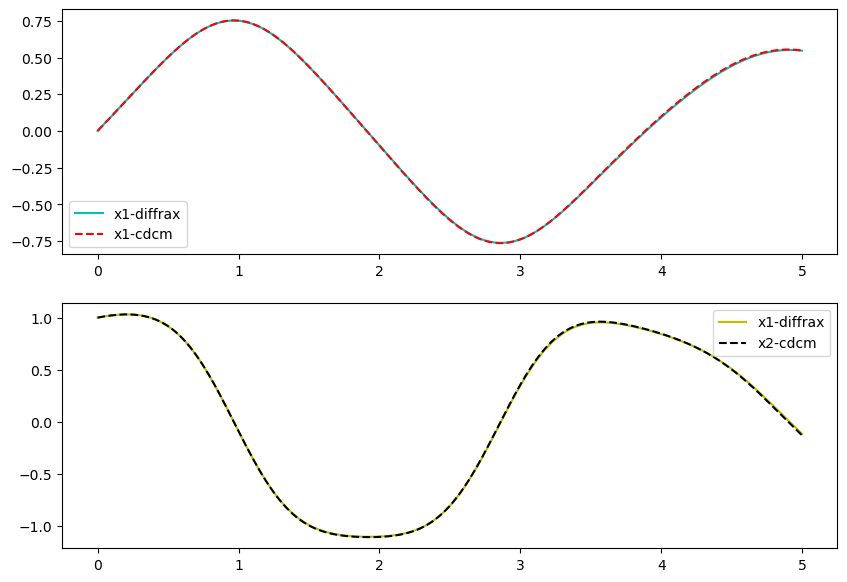

In [10]:
fig,ax=plt.subplots(2,1,figsize=(10,7))
ax[0].plot(t_data,sol.ys[:,sol_idx[0]],'c',label='x1-diffrax')
ax[0].plot(t_data,x1s,'--r',label='x1-cdcm')
ax[1].plot(t_data,sol.ys[:,sol_idx[1]],'y',label='x1-diffrax')
ax[1].plot(t_data,x2s,'--k',label='x2-cdcm')
ax[0].legend()
ax[1].legend()
plt.show()